<a href="https://colab.research.google.com/github/aneeshbal/SimpylCellCounter/blob/master/cnn_for_overlap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialize Session

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

## Create Training Data

In [0]:
def createImg(num_of_objects):
    
    global im, sizes, intensities
    
    im = np.random.randint(165, 200, size = (100, 100)).astype('uint8')
    obj_num = num_of_objects
    circle_centers = np.random.randint(25, 75, size = (obj_num, 2))
    intensities = np.random.randint(80, 90, size = (obj_num, 1)).astype('int')
    sizes = np.random.randint(8, 12, size = (obj_num, 1)).astype('int')

    for jj in range(len(circle_centers)):
        cv2.circle(im, (circle_centers[jj][0], circle_centers[jj][1]), sizes[jj], int(intensities[jj]), -1)
        
    ## blur image
    im = cv2.medianBlur(im, 3)
    im = cv2.GaussianBlur(im, (3,3), 9)
    
    return im

In [99]:
training_data = []
imgSize = 100
overlapping_cells = 5
cells_per_class = 10000
len_train = int(overlapping_cells * cells_per_class)

def create_training_data():
    for j in tqdm(range(0, len_train)):
        num_obj = np.random.randint(1,overlapping_cells)
        img = createImg(num_obj)
        label = int(num_obj-1)
        ret, img2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        training_data.append([img2, label])
        
        
create_training_data()
print(len(training_data))

import random
random.shuffle(training_data)


50000


In [100]:
X = []
y = []

for features, labels in training_data:
    X.append(features)
    y.append(labels)
  
  
X = np.array(X).reshape(-1, imgSize, imgSize, 1)
y = np.array(y)

X = X.astype('float32')/255.

from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

print(X.shape)
print(y.shape)

(50000, 100, 100, 1)
(50000, 4)


In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

del X, y, training_data

(40000, 100, 100, 1)
(10000, 100, 100, 1)
(40000, 4)
(10000, 4)


In [102]:
# if training on TPU...
## confirm sizes of arrays...if any array > 2GB, won't fit in TPU

print(X_train.nbytes/1e9)
print(X_test.nbytes/1e9)
print(y_train.nbytes/1e9)
print(y_test.nbytes/1e9)

1.6
0.4
0.00064
0.00016


## Model Selection

### Model 1 - Standard

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.constraints import *
from tensorflow.keras.regularizers import *

def make_model():
  input_img = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))

  conv1 = Conv2D(64, 3, activation='relu', padding='same')(input_img)
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D((2,2))(conv1)

  conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D((2,2))(conv2)

  conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
  pool4 = MaxPooling2D((2,2))(conv3)

  avg = GlobalAveragePooling2D()(pool4)
  dense = Dense(y_train.shape[1], activation='softmax')(avg)

  model = Model(input_img, dense)
  return model

### Model 2 - Residual

In [0]:
# convolution - 85% on standard set validation data
## check dropout and additional layers!

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.constraints import *
from tensorflow.keras.regularizers import *

p = 'same'

def additive_block(x, filters, size, activation='relu', drop1=0.3, drop2=0.3):

  conv1 = Conv2D(filters, size, padding=p)(x)
  a1 = Activation('relu')(conv1)
  conv2 = Conv2D(filters, size, padding=p)(a1)
  p1 = MaxPooling2D((2,2))(conv2)
  d1 = Dropout(drop1)(p1)
  a2 = Activation('relu')(d1)

  conv3 = Conv2D(filters, size, padding=p)(conv2)
  a3 = Activation('relu')(conv3)
  conv4 = Conv2D(filters, size, padding=p)(a3)
  p2 = MaxPooling2D((2,2))(conv4)
  d2 = Dropout(drop2)(p2)
  a4 = Activation('relu')(d2)
  add1 = Concatenate()([a2, a4])
  return add1


def make_model():
  input_img = Input(shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]))
  downblock1 = additive_block(input_img, 64, 3) # 50-size
  downblock2 = additive_block(downblock1, 128, 3) # 25-size
  downblock3 = additive_block(downblock2, 256, 3) # 12-size
  avg = GlobalAveragePooling2D()(downblock3)
  dense = Dense(y_train.shape[1], activation='softmax')(avg)

  model = Model(input_img, dense)
  return model
  

# GPU Training 
#### Preferred form of training, but will take longer

## Compile Model

In [16]:
lr = 1e-4

model = make_model()
model.compile(
  optimizer=tf.keras.optimizers.Adamax(learning_rate=lr),
  loss='categorical_crossentropy',
  metrics=['accuracy'])
print('Model built and compiled')
  
def scheduler(epoch):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(0.005 * (20 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

Model built and compiled


## Train Model

In [17]:
h = model.fit(X_train, y_train, 
              validation_data=(X_test, y_test),
              batch_size=128,
              epochs=100,
              callbacks=[callback])

Epoch 1/100
375/375 [==============================] - 51s 136ms/step - loss: 1.0216 - accuracy: 0.5539 - val_loss: 0.7003 - val_accuracy: 0.6826 - lr: 1.0000e-04
Epoch 2/100
375/375 [==============================] - 51s 135ms/step - loss: 0.6653 - accuracy: 0.7050 - val_loss: 0.6374 - val_accuracy: 0.7218 - lr: 1.0000e-04
Epoch 3/100
375/375 [==============================] - 51s 135ms/step - loss: 0.6374 - accuracy: 0.7128 - val_loss: 0.6422 - val_accuracy: 0.7048 - lr: 1.0000e-04
Epoch 4/100
375/375 [==============================] - 51s 135ms/step - loss: 0.6290 - accuracy: 0.7178 - val_loss: 0.6223 - val_accuracy: 0.7143 - lr: 1.0000e-04
Epoch 5/100
375/375 [==============================] - 50s 135ms/step - loss: 0.6289 - accuracy: 0.7161 - val_loss: 0.6255 - val_accuracy: 0.7218 - lr: 1.0000e-04
Epoch 6/100
324/375 [========================>.....] - ETA: 6s - loss: 0.6237 - accuracy: 0.7212

KeyboardInterrupt: ignored

## Plot Model

In [0]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])

plt.figure()
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])

# TPU Training

## Compile Model on TPU

In [0]:
import os
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [104]:
lr = 1e-3

with strategy.scope():
  model = make_model()
  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
print('Model built and compiled')
  
def scheduler(epoch):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(0.05 * (20 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

Model built and compiled


In [0]:
newlr = []
for j in range(0, 500):
  newlr.append(scheduler(j))
plt.plot(newlr)

## Format Data and Train Network

In [0]:
# for data as tensors 
b_s = 1024  ## Best batch_size is to be determined for classification problems...
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.shuffle(buffer_size=100).batch(b_s)

test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = test_data.shuffle(buffer_size=100).batch(b_s)
print('Formatting data...')

# set this to avoid retracing warnings during training, note that other tensorflow warnings will be disabled as well!
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print('Beginning training...')
## train model
with strategy.scope():
  h = model.fit(train_data,
                validation_data=test_data,
                batch_size=b_s,
                epochs=50,
                callbacks=[callback])

# Evaluate Results

In [108]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 5s 15ms/step - accuracy: 0.9378 - loss: 0.1837


[0.1837008148431778, 0.9377999901771545]

## Predict

In [109]:
d_imgs = model.predict(X_test)
print(d_imgs.shape)

(10000, 4)


Ground truth is 3
Prediction is 3


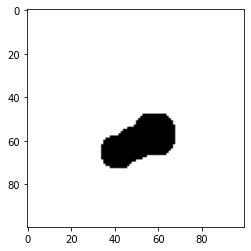

In [111]:
index = 196
plt.figure()
plt.imshow(X_test[index,:,:,0], cmap=plt.cm.gray)
print('Ground truth is', np.argmax(y_test[index])+1)
print('Prediction is', np.argmax(d_imgs[index])+1)

## Save Model

In [112]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/SCC_1x

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/SCC_1x


In [0]:
## even if you cd into a directory, still define the full path when saving...had some issues with colab with this before

#model.save('/content/drive/My Drive/SCC_1x/res_{}x.h5'.format(overlapping_cells))
#model.save_weights('/content/drive/My Drive/SCC_1x/res_{}x_weights.h5'.format(overlapping_cells))

# Plot Model Architecture

In [0]:
## plot model architecture
from tensorflow.keras.utils import plot_model
plot_model(model)